## Shelter Animal Outcomes
### MIDS W207 Final Project
### Clay Miller, Roseanna Hopper, Yubo Zhang

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#import tensorflow 
#import keras
import itertools

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher, DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from bokeh.charts import Bar, output_file, show, output_notebook
#from keras.models import Sequential
#from keras.layers import Dense, Activation
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn import tree

output_notebook()


%matplotlib inline

Loading BokehJS ...

In [31]:
# Load the data
data = pd.read_csv('../data/train.csv')
breeds = pd.read_csv('../data/breeds.csv')
breeds['Breed'] = breeds['Breed'].str.strip()
top_breed_list = []
for b in breeds['Breed']:
    top_breed_list.append(b.strip())
data['OutcomeSubtype'] = data['OutcomeSubtype'].fillna('')
data['Female'] = 'Female' in data['SexuponOutcome']
data['AgeuponOutcome'].fillna('', inplace = True)

def ageConvert(age):
    regexyear = '(\d+) year'
    regexmnth = '(\d+) month'
    regexwk = '(\d+) week'
    regexday = '(\d+) day'
    if re.match(regexyear, age):
        const = int(re.match(regexyear, age).groups()[0])
        return const*52
    elif re.match(regexmnth, age):
        const = int(re.match(regexmnth, age).groups()[0])
        return const*4.5 # a month is roughly 4.5 weeks
    elif re.match(regexwk, age):
        return int(re.match(regexwk, age).groups()[0])
    elif re.match(regexday, age):
        const = int(re.match(regexday, age).groups()[0])
        return const/7 #7 days in a week
    else:
        return None
    
data['ConvertedAge']=data['AgeuponOutcome'].apply(ageConvert)


def female(i):
    i = str(i)
    if i.find('Female') >= 0: return 'Female'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Male'
data['Female'] = data.SexuponOutcome.apply(female)

def intact(i):
    i = str(i)
    if i.find('Intact') >= 0: return 'Intact'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Spayed/Neutered'
data['Intact'] = data.SexuponOutcome.apply(intact)

def mixed_breed(i):
    i = str(i)
    if i.find('Mix') >= 0: return 'Mixed Breed'
    if i.find('/') >= 0: return 'Known Breed Combo'
    return 'Nonmixed'
data['MixedBreed'] = data.Breed.apply(mixed_breed)

def top_breed(i):
    i = str(i)
    if any(word in i for word in top_breed_list):
        return int(1)
    else:
        return int(0)
data['TopBreed'] = data.Breed.apply(top_breed)

def breed_rank(i):
    i = str(i)
    ranks = []
    for word in top_breed_list:
        if word in i:
            ranks.append(int(breeds.loc[breeds['Breed'] == word]['2007']))
    if len(ranks) > 0:
        return np.mean(ranks)
    else:
        return 51.0
data['BreedRank'] = data.Breed.apply(breed_rank)

def pit_bull(i):
    i = str(i)
    if i.find("Pit Bull") >=0: return int(1)
    else: return int(0)
data['PitBull'] = data.Breed.apply(pit_bull)

def black_cat(i):
    i = str(i)
    if i == "Black": return int(1)
    else: return int(0)
data['BlackCat'] = data.Color.apply(black_cat)

def naming(i):
    if pd.isnull(i): return 'Unnamed'
    return 'Named'
data['Named'] = data.Name.apply(naming)

#Change all breed and color strings so that they are ordered consistently
#E.G. all "brown/black" and "black/brown" should become "black, brown"
def reorder(i):
    i = str(i)
    if i.find(" ") >= 0: i = i.replace(" ", "-")
    if i.find("/") >= 0: i = i.replace("/", " ")
    i = i.split()
    i = sorted(i)
    i = ' '.join(i)
    return i

data['OrderedColor'] = data.Color.apply(reorder)
data['OrderedBreed'] = data.Breed.apply(reorder)


In [32]:
#Remove unnecessary variables
#del data['AnimalID']
#del data['Name']
#del data['DateTime']
#del data['Breed']
#del data['OutcomeSubtype']
#del data['SexuponOutcome']
#del data['AgeuponOutcome']
#del data['Color']
#del data['OrderedBreed']
#del data['OrderedColor']

continuous = {'dog':['ConvertedAge', 'BreedRank'], 'cat':['ConvertedAge']}
discrete = {'dog':[
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named',
    'TopBreed',
    'PitBull'
], 'cat': [
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named',
    'BlackCat'
]}


predictors = {'dog': continuous['dog'] + discrete['dog'], 'cat':continuous['cat']+discrete['cat']}
target = 'OutcomeType'

#For those missing an age, fill with the median age by animal type
data["ConvertedAge"] = data.groupby("AnimalType").transform(lambda x: x.fillna(x.median()))
data[continuous['dog']].describe().T

,count,mean,std,min,25%,50%,75%,max
ConvertedAge,26729.0,113.370253,154.064766,0.0,9.0,52.0,156.0,1040.0
BreedRank,26729.0,35.975981,20.246237,1.0,12.0,51.0,51.0,51.0


In [33]:
#Turn categorical variables into binaries
data2_dog = pd.concat([data[target], data[continuous['dog']], pd.get_dummies(data[discrete['dog']])], axis=1)
data2_cat = pd.concat([data[target], data[continuous['cat']], pd.get_dummies(data[discrete['cat']])], axis=1)

print data2_dog.head()
print data2_cat.head()
print data2_dog.shape
print data2_cat.shape

       OutcomeType  ConvertedAge  BreedRank  TopBreed  PitBull  \
0  Return_to_owner          52.0       20.0         1        0   
1       Euthanasia          52.0       51.0         0        0   
2         Adoption         104.0       51.0         0        1   
3         Transfer           3.0       51.0         0        0   
4         Transfer         104.0       28.5         1        0   

   AnimalType_Cat  AnimalType_Dog  Female_Female  Female_Male  Female_Unknown  \
0               0               1              0            1               0   
1               1               0              1            0               0   
2               0               1              0            1               0   
3               1               0              0            1               0   
4               0               1              0            1               0   

   Intact_Intact  Intact_Spayed/Neutered  Intact_Unknown  \
0              0                       1               0

In [34]:
discrete_dog = ['AnimalType_Cat', 'AnimalType_Dog', 'Female_Female', 'Female_Male', 'Female_Unknown',
           'Intact_Intact', 'Intact_Spayed/Neutered', 'Intact_Unknown', 'MixedBreed_Known Breed Combo',
           'MixedBreed_Mixed Breed', 'MixedBreed_Nonmixed', 'Named_Named', 'Named_Unnamed', 'TopBreed', 'PitBull']

discrete_cat = ['AnimalType_Cat', 'AnimalType_Dog', 'Female_Female', 'Female_Male', 'Female_Unknown',
           'Intact_Intact', 'Intact_Spayed/Neutered', 'Intact_Unknown', 'MixedBreed_Known Breed Combo',
           'MixedBreed_Mixed Breed', 'MixedBreed_Nonmixed', 'Named_Named', 'Named_Unnamed', 'BlackCat']

predictors_dog = continuous['dog'] + discrete_dog
predictors_cat = continuous['cat'] + discrete_cat

# Train/test split
X_dog = data2_dog[data2_dog['AnimalType_Dog'] == 1][predictors_dog]
y_dog = data2_dog[data2_dog['AnimalType_Dog'] == 1][[target]]
X_dog_train, X_dog_dev, y_dog_train, y_dog_dev = train_test_split(X_dog, y_dog, random_state=2)

X_cat = data2_cat[data2_cat['AnimalType_Cat'] == 1][predictors_cat]
y_cat = data2_cat[data2_cat['AnimalType_Cat'] == 1][[target]]
X_cat_train, X_cat_dev, y_cat_train, y_cat_dev = train_test_split(X_cat, y_cat, random_state=2)

#Normalize 
ss_dog = StandardScaler()
ss_dog.fit(X_dog_train[continuous['dog']])   # Compute mean and std of training data
X_dog_train[continuous['dog']] = ss_dog.transform(X_dog_train[continuous['dog']])  # Use that mean and std to normalize columns of training data
X_dog_dev[continuous['dog']] = ss_dog.transform(X_dog_dev[continuous['dog']]) 
print X_dog.head()

ss_cat = StandardScaler()
ss_cat.fit(X_cat_train[continuous['cat']])   # Compute mean and std of training data
X_cat_train[continuous['cat']] = ss_cat.transform(X_cat_train[continuous['cat']])  # Use that mean and std to normalize columns of training data
X_cat_dev[continuous['cat']] = ss_cat.transform(X_cat_dev[continuous['cat']]) 
print X_cat.head()

C:\Users\Clay\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Clay\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   ConvertedAge  BreedRank  AnimalType_Cat  AnimalType_Dog  Female_Female  \
0          52.0       20.0               0               1              0   
2         104.0       51.0               0               1              0   
4         104.0       28.5               0               1              0   
5           4.5       30.0               0               1              1   
8          22.5       51.0               0               1              1   

   Female_Male  Female_Unknown  Intact_Intact  Intact_Spayed/Neutered  \
0            1               0              0                       1   
2            1               0              0                       1   
4            1               0              0                       1   
5            0               0              1                       0   
8            0               0              0                       1   

   Intact_Unknown  MixedBreed_Known Breed Combo  MixedBreed_Mixed Breed  \
0               0      

C:\Users\Clay\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


    ConvertedAge  AnimalType_Cat  AnimalType_Dog  Female_Female  Female_Male  \
1           52.0               1               0              1            0   
3            3.0               1               0              0            1   
6            3.0               1               0              0            1   
7            3.0               1               0              0            0   
10         104.0               1               0              0            0   

    Female_Unknown  Intact_Intact  Intact_Spayed/Neutered  Intact_Unknown  \
1                0              0                       1               0   
3                0              1                       0               0   
6                0              1                       0               0   
7                1              0                       0               1   
10               1              0                       0               1   

    MixedBreed_Known Breed Combo  MixedBreed_Mixed Breed

C:\Users\Clay\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Visualizing Features

In [ ]:
#A quick look at the variables

#Animal types
animal_type = data['AnimalType'].value_counts() 
animal_type.plot(kind='bar',color='#34ABD8',rot=0)

In [ ]:
#Animal types
p = Bar(data, label='OutcomeType', values = 'AnimalType', agg='count', stack='AnimalType',
        title="Outcomes by Animal Type", legend='top_right')
show(p)

In [ ]:
#Outcome types
outcome_type = data['OutcomeType'].value_counts() 
outcome_type.plot(kind='bar',color='#34ABD8',rot=0)

In [ ]:
#Spayed/neutered
intact_type = data['Intact'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [ ]:
p = Bar(data, label='OutcomeType', values = 'Intact', agg='count', stack='Intact',
        title="Outcomes by Intact Status", legend='top_right')
show(p)

In [ ]:
#Sex
intact_type = data['Female'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [ ]:
p = Bar(data, label='OutcomeType', values = 'Female', agg='count', stack='Female',
        title="Outcomes by Female", legend='top_right')
show(p)

In [ ]:
#Purebred/mixed

mixed_breed = data['MixedBreed'].value_counts() 
mixed_breed.plot(kind='bar',color='#34ABD8',rot=0)

In [ ]:
p = Bar(data, label='OutcomeType', values = 'MixedBreed', agg='count', stack='MixedBreed',
        title="Outcomes by Breed Type", legend='top_right')
show(p)

In [ ]:
data.hist(column="ConvertedAge", bins=25)

In [ ]:
p = Bar(data, label='OutcomeType', values = 'ConvertedAge', agg='mean',
        title="Outcomes by Age", legend='top_right')
show(p)

In [ ]:
#Named/unnamed

name = data['Named'].value_counts() 
name.plot(kind='bar',color='#34ABD8',rot=0)

In [ ]:
p = Bar(data, label='OutcomeType', values = 'Named', agg='count', stack='Named',
        title="Outcomes by Name Status", legend='top_right')
show(p)

In [ ]:
OrderedColor = data.OrderedColor.unique()
print("Unique Colors" , (data.OrderedColor.value_counts() > 0).sum())
print(OrderedColor)

In [ ]:
OrderedBreed = data.OrderedBreed.unique()
print("Unique Breeds" , (data.OrderedBreed.value_counts() > 0).sum())
print(OrderedBreed)

### LOGISTIC REGRESSION

#### Generate logistic regression

In [ ]:
# Select C from 0.00001, 0.0001, 0.001, 0.01, 0.1,, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0 and the highes accuracy is when C=0.5

for m in [ 0.5]: # 0.00001, 0.0001, 0.001, 0.01, 0.1,, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_train, y_train)
    weight1 = lrq.coef_
    sum1 = sum(sum(weight1))
    print 'The mean accuracy when the regularization strength C is', m,  'is ', lrq.score(X_dev, y_dev), 'and the sum of the squared weight is', sum1


#### Feature engineering

For this dataset, we have 14 different features, including gender, breed, age and so on.  In order to select the best
feature to add to the model, we can go either bottom up starting from only 1 feature and add more feature based on
the accuracy, or go down by deleting features. 



In [ ]:
# Start the bottom up feature selection with Greedy algorithm 
# Compute the accuracy of logistic regression with N features

train = X_train
dev = X_dev

bestVec = [] 

for j in range(14):
    maxacc = 0
    maxi = 0
    for i in range(14):
        if i not in bestVec:
            X_train_eng = pd.DataFrame(train.ix[:, bestVec + [i]])
            X_dev_eng = pd.DataFrame(dev.ix[:, bestVec + [i]])
            m=.5
            lrq = LogisticRegression(C = m, penalty = 'l2')
            lrq.fit(X_train_eng, y_train)
            if lrq.score(X_dev_eng, y_dev) > maxacc:
                maxacc = lrq.score(X_dev_eng, y_dev)
                maxi = i
    bestVec = bestVec + [maxi]
    print 'When the number of features used is ', j+1 ,', the best feature to add to the model is ', predictors[maxi] ,', and the accurancy is', maxacc

We can see from the above that when the number of feature is 6, the model has the highest accuracy of 0.634744875056, 
the model did not increase the accurcy by adding additional features. 

The six features include: Intact_Spayed/Neutered, ConvertedAge, AnimalType_Cat, MixedBreed_Known Breed Combo, Named_Unnamed, and MixedBreed_Nonmixed.  Next we will exam each features to evaluate each impact on the overal outcome.

#### Check Spayed/Neutered 

Since Spayed/Neutered is the first feature from the logistic regression list, it would be interesting to check if the data with only Spayed/Neutered and the data with only intact have better accuracy than original dataset. 

In [ ]:
# Dataset with only Spayed/Neutered and intact
X_spayed = train[train['Intact_Spayed/Neutered'] == 1]
X_intact = train[train['Intact_Intact'] == 1]

y_spayed = y_train[train['Intact_Spayed/Neutered'] == 1]
y_intact = y_train[train['Intact_Intact'] == 1]

Xdev_spayed = dev[dev['Intact_Spayed/Neutered'] == 1]
Xdev_intact = dev[dev['Intact_Intact'] == 1]

ydev_spayed = y_dev[dev['Intact_Spayed/Neutered'] == 1]
ydev_intact = y_dev[dev['Intact_Intact'] == 1]


In [ ]:
# logistic regression with only Spayed/Neutered 
for m in [0.1]:     # [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_spayed, y_spayed)
    print 'The mean accuracy when the regularization strength C for Spayed/Neutered dataset', m,  'is ', lrq.score(Xdev_spayed, ydev_spayed)

In [ ]:
# logistic regression with only intact
for m in [0.1]:     # [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_intact, y_intact)
    print 'The mean accuracy when the regularization strength C for intact dataset', m,  'is ', lrq.score(Xdev_intact, ydev_intact)

Looks like the dataset with only intact animal have a better accuracy than the original dataset. 

#### Check ConvertedAge

Let's exam the age impact on the accuracy of the data. Consider kitten/puppy is from 0-1 year old, adult cat/dog is 1-7 years old, and senior/mature cat/dog is larger than 7 years old. The data can be divided into three dataset: youth, adult and senior. 

In [ ]:
# Dataset with youth, adult and senior pets

X_youth = train[train['ConvertedAge'] <= 52]
X_adult = 52 < train[train['ConvertedAge'] < 364]
X_senior = train[train['ConvertedAge'] >= 364]

y_youth = y_train[train['ConvertedAge'] <= 52]
y_adult = 52 < y_train[train['ConvertedAge'] < 364]
y_senior = y_train[train['ConvertedAge'] >= 364]

Xdev_youth = dev[dev['ConvertedAge'] <= 52]
Xdev_adult = 52 < dev[dev['ConvertedAge'] < 364]
Xdev_senior = dev[dev['ConvertedAge'] >= 364]

ydev_youth = y_dev[dev['ConvertedAge'] <= 52]
ydev_adult = 52 < y_dev[dev['ConvertedAge'] < 364]
ydev_senior = y_dev[dev['ConvertedAge'] >= 364]

In [ ]:
# Logistic regression with youth pets

for m in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]:
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_youth, y_youth)
    print 'The mean accuracy when the regularization strength C for kitten/puppy dataset', m,  'is ', lrq.score(Xdev_youth, ydev_youth)

#### Decision trees

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train[predictors], y_train_hot)

pred = dt.predict(X_train[predictors])
print pred
mse = np.mean( (pred - y_train_hot) ** 2)
print 'Mean squared error = {}'.format(mse)
print 'The accuracy is',dt.score(X_train[predictors], y_train_hot)

Looks like we only get 0.35 on accuracy with decision trees on the training data

#### Random forest

In [ ]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=50, oob_score=True)
scores = cross_val_score(rf, X_train[predictors], y_train_hot, cv=10)
print scores.mean()

### Neural Network 

We will use Keras for neural network training. 

In [ ]:
# hot encoding to transform training and development data
lb_style = LabelBinarizer()
y_train_hot = lb_style.fit_transform(y_train)
y_train_hot
y_dev_hot = lb_style.fit_transform(y_dev)

In [ ]:
# using keras to predict the accuracy
model = Sequential([
    Dense(32, input_shape=(14,)),
    Activation('sigmoid'),
    Dense(5),
    Activation('softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(np.array(X_train), y_train_hot, epochs=10, batch_size=32)

In [ ]:
score = model.evaluate(np.array(X_dev), y_dev_hot, batch_size=16)

print '\nAccurancy on test data', score[1]

The accuracy shows that neural network gives a higher accuracy than logistic regression

Logistic Regression Pipeline

In [89]:
# Train/test split
discrete = {'dog':[
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named',
    'TopBreed',
    'PitBull'
], 'cat': [
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named',
    'BlackCat'
]}
data_dog = data[data['AnimalType'] == 'Dog']
data_cat = data[data['AnimalType'] == 'Cat']
X_dog = data_dog[predictors['dog']]
X_cat = data_cat[predictors['cat']]
y_dog = data_dog[[target]]
y_cat = data_cat[[target]]
X_dog_train, X_dog_dev, y_dog_train, y_dog_dev = train_test_split(X_dog, y_dog, random_state=2)
X_cat_train, X_cat_dev, y_cat_train, y_cat_dev = train_test_split(X_cat, y_cat, random_state=2)


In [21]:
class MyVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, cols, hashing=None):
        """
        args:
            cols: a list of column names of the categorical variables
            hashing: 
                If None, then vectorization is a simple one-hot-encoding.
                If an integer, then hashing is the number of features in the output.
        """
        self.cols = cols
        self.hashing = hashing
        
    def fit(self, X, y=None):

        data = X[self.cols]
        
        # Choose a vectorizer
        if self.hashing is None:
            self.myvec = DictVectorizer(sparse=False)
        else:
            self.myvec = FeatureHasher(n_features = self.hashing)
    
        self.myvec.fit(X[self.cols].to_dict(orient='records'))
        return self
            
    def transform(self, X):
            
        # Vectorize Input
        if self.hashing is None:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')),
                columns = self.myvec.feature_names_
            )
        else:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')).toarray()
            )

In [22]:
class MyScaler():
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        self.ss = StandardScaler()
        self.ss.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return self.ss.transform(X[self.cols])

In [49]:
discrete_pipe_dog = Pipeline(steps=[('Vectorizer', MyVectorizer(cols=discrete['dog'], hashing=None))])
discrete_pipe_cat = Pipeline(steps=[('Vectorizer', MyVectorizer(cols=discrete['cat'], hashing=None))])

continuous_pipe_cat = Pipeline(steps=[('Scale', MyScaler(continuous['cat']))])
continuous_pipe_dog = Pipeline(steps=[('Scale', MyScaler(continuous['dog']))])

union_dog = FeatureUnion([('Discrete', discrete_pipe_dog), ('Continuous', continuous_pipe_dog)])
union_cat = FeatureUnion([('Discrete', discrete_pipe_cat), ('Continuous', continuous_pipe_cat)])


In [50]:
pipeline_dog = Pipeline([('Preprocess', FeatureUnion([('Discrete', discrete_pipe_dog), ('Continuous', continuous_pipe_dog)])),
                      ('Predict', LogisticRegression(multi_class='multinomial', solver='newton-cg', C = 0.25))])
pipeline_cat = Pipeline([('Preprocess', FeatureUnion([('Discrete', discrete_pipe_cat), ('Continuous', continuous_pipe_cat)])),
                      ('Predict', LogisticRegression(multi_class='multinomial', solver='newton-cg', C= 0.25))])

test_dog_lr = pipeline_dog.fit(X_dog_train, y_dog_train)
test_cat_lr = pipeline_cat.fit(X_cat_train, y_cat_train)

In [30]:
print "Multinomial Logistic Regression Train Accuracy :: ", metrics.accuracy_score(y_cat_train, test_cat_lr.predict(X_cat_train))
print "Multinomial Logistic Regression Dev Accuracy :: ", metrics.accuracy_score(y_cat_dev, test_cat_lr.predict(X_cat_dev))
print
print "Multinomial Logistic Regression Train Accuracy :: ", metrics.accuracy_score(y_dog_train, test_dog_lr.predict(X_dog_train))
print "Multinomial Logistic Regression Dev Accuracy :: ", metrics.accuracy_score(y_dog_dev, test_dog_lr.predict(X_dog_dev))
 

Multinomial Logistic Regression Train Accuracy ::  0.738203592814
Multinomial Logistic Regression Dev Accuracy ::  0.74066091954

Multinomial Logistic Regression Train Accuracy ::  0.562670998632
Multinomial Logistic Regression Dev Accuracy ::  0.577840471916


In [92]:
X_dog_train_pipeline = union_dog.fit_transform(X_dog_train)
X_dog_dev_pipeline = union_dog.transform(X_dog_dev)
print X_dog_train_pipeline[0:5]
logit_reg = LogisticRegression(penalty="l2", multi_class='multinomial', solver='newton-cg') 
c,r = y_dog_train.shape
y_dog_train = pd.Series(y_dog_train).values.reshape(c,)
param_domain = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5.0, 10.0]
param_dict = dict(C = param_domain)
#gridsearch = GridSearchCV(logit_reg, param_dict)
#gridsearch.fit(X_dog_train_pipeline, y_dog_train)

[[ 1.    1.    0.    0.    0.    1.    0.    0.    1.    0.    1.    0.    0.
   1.   -0.57 -0.74]
 [ 1.    1.    0.    0.    0.    1.    0.    0.    1.    0.    1.    0.    0.
   0.   -0.67  1.25]
 [ 1.    0.    1.    0.    0.    1.    0.    0.    1.    0.    1.    0.    0.
   0.    0.72  1.25]
 [ 1.    1.    0.    0.    0.    1.    0.    0.    1.    0.    0.    1.    0.
   1.   -0.57 -0.45]
 [ 1.    0.    1.    0.    0.    1.    0.    1.    0.    0.    1.    0.    0.
   1.   -0.76 -0.62]]


In [30]:
print X_dog_train.head()

       ConvertedAge  BreedRank  AnimalType_Cat  AnimalType_Dog  Female_Female  \
25479     -0.571459  -0.740373               0               1              1   
25079     -0.671171   1.245512               0               1              1   
26347      0.724798   1.245512               0               1              0   
17579     -0.571459  -0.449756               0               1              1   
24034     -0.755304  -0.619283               0               1              0   

       Female_Male  Female_Unknown  Intact_Intact  Intact_Spayed/Neutered  \
25479            0               0              0                       1   
25079            0               0              0                       1   
26347            1               0              0                       1   
17579            0               0              0                       1   
24034            1               0              0                       1   

       Intact_Unknown  MixedBreed_Known Breed Comb

In [73]:
#Find the Best regularization strength
      #Generate logistic regression
def logit_reg(X_train, X_dev, y_train, y_dev, predict_anim):
    logit_reg = LogisticRegression(penalty="l2", multi_class='multinomial', solver='newton-cg')  
    print X_train.shape
    print type(pd.Series(y_train))
    #need labels to be in (R,) shape not (R,1) shape
    #c,r = y_train.shape
    #y_train = pd.Series(y_train).reshape(c,)
    #print y_train.shape
    y_train = y_train.values.ravel()
    y_dev = y_dev.values.ravel()
    
    #Test C within [0.001, 10]
    param_domain = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5.0, 10.0]
    param_dict = dict(C = param_domain)
    print param_dict

    #Initialize GridSearchCV to identify the optimal parameter values
    gridsearch = GridSearchCV(logit_reg, param_dict)
    gridsearch.fit(X_train, y_train)

    #Generate model at the best C value
    C = gridsearch.best_params_["C"]
    print "Train data: Logistic Regression score at C=%.3f: %f" % (C, gridsearch.best_score_)
    print ('\n' * 1)
    logit_reg = LogisticRegression(C=C, penalty="l2")
    logit_reg.fit(X_train, y_train)

    #Predict on the X_dev set
    logit_reg_dev = logit_reg.predict(X_dev)

    #Generate classification report
    print "Classification Report:"
    print " "
    print classification_report(y_dev, logit_reg_dev, target_names=y_dev)
    print "Dev data: Logistic Regression score at C=%.3f: %f" % (C, metrics.f1_score(y_dev, logit_reg_dev, average="weighted"))    
    print "Weights:"
    #Get the variables with the highest weights for each outcome
    print logit_reg.classes_
    weights = []
    for i in range(len(logit_reg.classes_)):
        top_vars = np.argsort(logit_reg.coef_[i])[-6:-1]
        print logit_reg.classes_[i]
        for j in top_vars:
            print predict_anim[j], round(logit_reg.coef_[i][j],3)
        print
    print ('\n' * 2)


    #Generate logistic regression and add the squared weight values to an array, at each C
    logit_reg_coeff = []
    for c in param_domain:
        logit_reg = LogisticRegression(C=c, penalty="l2") 
        logit_reg.fit(X_train, y_train)
        squared_weights = []
        squared_weights.append(c)                       
        for i in range(0, 4):
            [squared_weights.append(np.sum(np.power(logit_reg.coef_[i], 2)))]
        logit_reg_coeff.append(squared_weights)

    coeff = np.asarray(logit_reg_coeff, dtype = "object")


logit_reg(X_dog_train, X_dog_dev, y_dog_train, y_dog_dev, predictors_dog)
logit_reg(X_cat_train, X_cat_dev, y_cat_train, y_cat_dev, predictors_cat)

(11696, 17)
<class 'pandas.core.series.Series'>
{'C': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5.0, 10.0]}
Train data: Logistic Regression score at C=0.250: 0.561560


Classification Report:
 
                 precision    recall  f1-score   support

       Adoption       0.57      0.88      0.69      1629
       Adoption       0.00      0.00      0.00         9
       Transfer       0.38      0.02      0.03       187
       Adoption       0.53      0.34      0.42      1086
Return_to_owner       0.62      0.41      0.50       988

    avg / total       0.56      0.57      0.53      3899

Dev data: Logistic Regression score at C=0.250: 0.532516
Weights:
['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
Adoption
BreedRank -0.037
Female_Male -0.03
AnimalType_Cat 0.0
MixedBreed_Known Breed Combo 0.061
Female_Female 0.259

Died
Named_Unnamed -0.034
AnimalType_Cat 0.0
Female_Unknown 0.036
Intact_Unknown 0.036
Intact_Intact 0.049

Euthanasia
Female_Unknown 0.

In [67]:
print y_dog_train[target].unique()

['Return_to_owner' 'Adoption' 'Transfer' 'Euthanasia' 'Died']


Normalized confusion matrix
[[  3.76e-01   9.21e-04   5.23e-01   1.00e-01   0.00e+00]
 [  3.37e-01   5.88e-02   2.67e-01   3.37e-01   0.00e+00]
 [  1.02e-01   6.14e-04   8.80e-01   1.72e-02   0.00e+00]
 [  1.23e-01   8.10e-03   4.64e-01   4.05e-01   0.00e+00]
 [  1.11e-01   0.00e+00   2.22e-01   6.67e-01   0.00e+00]]
Normalized confusion matrix
[[ 0.07  0.04  0.84  0.06  0.  ]
 [ 0.03  0.14  0.08  0.75  0.  ]
 [ 0.01  0.    0.91  0.08  0.  ]
 [ 0.01  0.    0.21  0.78  0.  ]
 [ 0.    0.    0.12  0.88  0.  ]]


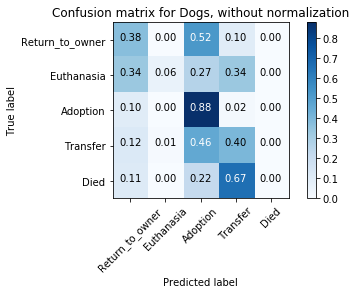

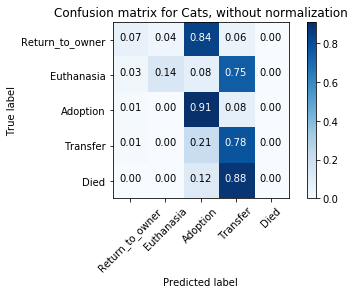

In [32]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']
cnf_dog_matrix = confusion_matrix(y_dog_dev, test_dog_lr.predict(X_dog_dev), labels = class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_dog_matrix, classes=class_names, normalize = True,
                      title='Confusion matrix for Dogs, without normalization')

cnf_cat_matrix = confusion_matrix(y_cat_dev, test_cat_lr.predict(X_cat_dev), labels = class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_cat_matrix, classes=class_names, normalize = True,
                      title='Confusion matrix for Cats, without normalization')
plt.show()